In [2]:
import sys
import matplotlib.pyplot as plt
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import keras.layers as kl
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Input, Concatenate
from tensorflow.keras.models import Model
import csv


path = 'C:/Users/ian03/Desktop/MLproject/Latest/AudioNNRep/functions'
sys.path.append('C:/Users/ian03/Desktop/MLproject/Latest/AudioNNRep/functions')

import functions as f

inst_path = "C:/Users/ian03/Desktop/MLproject/AudioNNRepository/audio/"

def torch_normalize(spec):
    return (spec - torch.min(spec)) / (torch.max(spec) - torch.min(spec))



In [ ]:
import sys
from google.colab import drive
drive.mount('/content/drive')

import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import keras.layers as kl
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Input, Concatenate
from tensorflow.keras.models import Model


path = '/content/drive/My Drive/Colab Notebooks/final project/'
sys.path.append('/content/drive/My Drive/Colab Notebooks/final project/')

import functions as f

inst_path = "/content/drive/My Drive/Colab Notebooks/final project/audio/"


In [3]:
#Initialize the list of instruments
filenames = f.read_files_in_dir(inst_path)
#pianos = [filename for filename in filenames if "piano" in filename] #empty
bass = [filename for filename in filenames if "bass" in filename]
guitar = [filename for filename in filenames if "guitar" in filename]
#drum = [filename for filename in filenames if "drum" in filename] #empty
flutes = [filename for filename in filenames if "flute" in filename]
keyboards = [filename for filename in filenames if "keyboard" in filename] 


instrument_list = [bass, guitar, flutes, keyboards]

<BarContainer object of 4 artists>

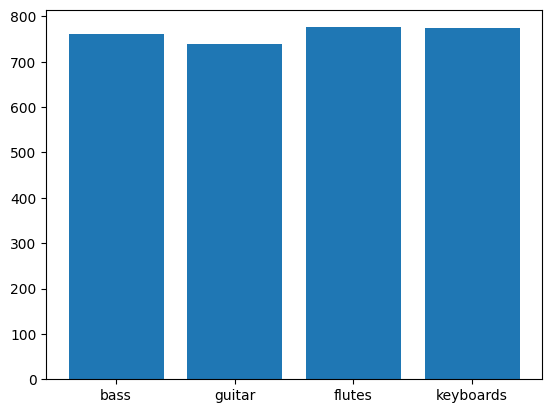

In [4]:
#Generate data
### NOTE: THE LABEL OUTPUT IS NON-NORMALIZED, this is important for the correct calculation of the penalty term in the loss function
data, labels, original_labels = f.nu_gen_mel_spectro(1500, instrument_list, path = inst_path, target_shape=(1025, 126))

#Plot the distribution of the data
num_bass = 0
num_guitar = 0
num_flutes = 0
num_keyboards = 0
for label1 in original_labels:
    for n, label in enumerate(label1):
        if label == 1:
            if n == 0:
                num_bass += 1
            elif n == 1:
                num_guitar += 1
            elif n == 2:
                num_flutes += 1
            elif n == 3:
                num_keyboards += 1
plt.figure()
plt.bar(['bass', 'guitar', 'flutes', 'keyboards'], [num_bass, num_guitar, num_flutes, num_keyboards])


In [6]:
class AudioDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


# Split the data into training and testing sets
#data = data[..., np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
print(y_train.shape)
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)
print(X_train.shape)

# Create the datasets and dataloaders
train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
#print(train_dataset[0][0].shape)

# Get a batch of data
inputs, targets = next(iter(train_loader))

# Print the shape of the inputs
print(inputs.shape)

(1200, 4, 128, 126)
(1200, 1, 128, 126)
torch.Size([2, 1, 128, 126])


In [7]:
# Initialize the model, loss function, and optimizer
import torch_directml

#device = torch_directml.device()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_channels = X_train.shape[1]  # Get the number of input channels from the data
#model = UNetDConv(in_channels=1,out_channels=4).to(device, dtype=torch.float32)
print(device)

cpu


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DilatedConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(DilatedConv, self).__init__()
        padding = (kernel_size - 1) * dilation // 2  # Add this line
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, dilation=dilation, padding=dilation)

    def forward(self, x):
        return self.conv(x)

class Attention(nn.Module):
    def __init__(self, in_channels):
        super(Attention, self).__init__()
        self.in_channels = in_channels
        self.attention = nn.MultiheadAttention(embed_dim=in_channels, num_heads=1, batch_first=True)

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        x = x.view(batch_size, channels, -1).permute(0, 2, 1)
        attn_output, _ = self.attention(x, x, x)
        attn_output = attn_output.permute(0, 2, 1).view(batch_size, self.in_channels, height, width)
        return attn_output

class DConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):  # Set in_channels to 1
        super(DConvBlock, self).__init__()
        padding = (kernel_size - 1) * 2 // 2
        self.dilated_conv = nn.Conv2d(in_channels, in_channels, kernel_size, padding=padding, dilation=2, groups=in_channels)
        self.pointwise_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.attention = Attention(out_channels)

    def forward(self, x):
        x = self.dilated_conv(x)
        x = self.pointwise_conv(x)
        x = self.attention(x)
        return x
    
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        
        # Decode the hidden state of the last time step
        return out

class UNetDConv(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_size, num_layers):
        super(UNetDConv, self).__init__()
        self.encoder = DConvBlock(in_channels, in_channels)
        self.bilstm = BiLSTM(in_channels, hidden_size, num_layers)  # Change input_size to in_channels
        self.decoder = DConvBlock(hidden_size*2, out_channels)  # Change the number of input channels to hidden_size*2 because it's bidirectional
        self.final_conv = nn.Conv2d(out_channels, out_channels, kernel_size=1)  # Change the number of input channels to out_channels

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        x = self.encoder(x)
        x = x.reshape(batch_size, height * width, channels)  # Flatten the spatial dimensions and sequence length to 1
        x = self.bilstm(x)
        x = x.reshape(batch_size, self.bilstm.hidden_size*2, height, width)  # Reshape back to (batch_size, channels, height, width)
        x = self.decoder(x)
        x = self.final_conv(x)
        return x
    
x = torch.randn(2, 1, 128, 126) #example input 
model = UNetDConv(in_channels=1, out_channels=4, hidden_size=4, num_layers=2)  # Example with 2 output channels
model.load_state_dict(torch.load('your_model_weights.pth'))

output = model(x).to(device, dtype=torch.float32)
print(output.shape)  # Should be (batch_size, out_channels, height, width)


torch.Size([2, 4, 128, 126])


(128, 126)
(1, 128, 126)


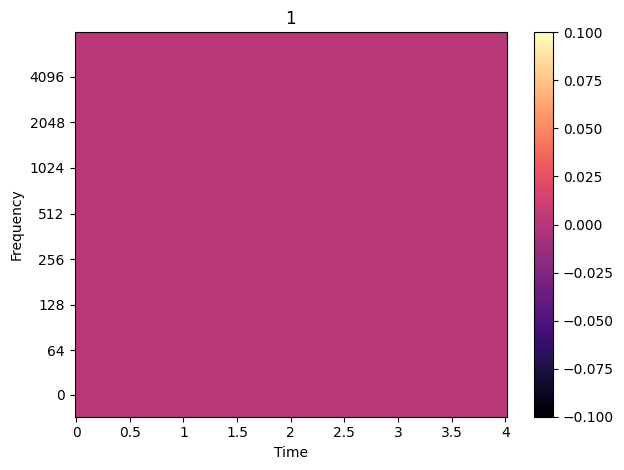

In [37]:
#Plot the spectrogram
plt.figure()

print(data[1].shape)
print(X_train[1].shape)
librosa.display.specshow(np.squeeze(y_train[1][2]), sr=16000, x_axis='time', y_axis='log')
plt.colorbar()
plt.title(1)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()



In [39]:
#### NOTE: The number of data entries should be divisible by the batch size

model = UNetDConv(in_channels=1, out_channels=4, hidden_size=4, num_layers=2).to(device, dtype = torch.float32)  # Example with 2 output channels
#model.load_state_dict(torch.load('your_model_weights.pth'))

class AbsoluteLogDifferenceLoss(nn.Module):
    def __init__(self):
        super(AbsoluteLogDifferenceLoss, self).__init__()

    def forward(self, y_pred, y_true, X):
        # Ensure that we avoid log of zero by adding a small epsilon
        epsilon = 1e-6
        # if y_pred is negative set it to 0
        #y_pred = torch.clamp(y_pred, min=0)
        # if y_pred is infite set it to 0
        log_diffs = 0
        for i in range(len(y_pred[1])):
            #Forsøg med
            log_diffs += torch.mean(torch_normalize(torch.abs(y_pred[:, i, :] - y_true[:,i,:])))
        
        sq_X = torch.squeeze(X)
        summed_spectrogram = torch.sum(y_pred, dim=1)

        diff = torch.abs(torch_normalize(summed_spectrogram) - torch_normalize(sq_X))

        penalty = torch.mean(diff)

        regulator = 100 * 1000

        loss = log_diffs + regulator * penalty #+ torch.mean(regulator*penalty)

        #print(np.shape(loss))
        return loss, regulator * penalty
    
class SDR(nn.Module):
    def __init__(self):
        super(SDR, self).__init__()
        self.batch = 0

    def forward(self, y_pred, y_true):
        # Ensure that we avoid log of zero by adding a small epsilon
        epsilon = 1e-7
        # Compute the numerator and denominator

        y_true = torch_normalize(y_true)
        y_pred = torch_normalize(y_pred)

        num = torch.sum(torch.square(torch.squeeze(y_true)), dim = (2, 3))
        den = torch.sum(torch.square(torch.squeeze(y_true - y_pred)), dim = (2, 3))

        scores = 10 * torch.log10((num + epsilon) / (den + epsilon))
        
        loss = -torch.mean(scores)

        print(f"batch {self.batch}, loss: {loss}")
        self.batch += 1
        penalty = 0
        return loss


criterion = SDR()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 1
best_loss = np.inf
patience = 0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X, y in train_loader:
        X, y = X.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)
        
        #print(f"Shape of x : {X.shape},Shape of y {y.shape}")
        optimizer.zero_grad() 
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0) # Accumulate loss
        #print(f"Loss: {loss.item()}")
    val_loss = 0.0
    model.eval()
    #Implement early stopping
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)
            y_pred = model(X)
            loss = criterion(y_pred, y)
            
            val_loss += 4*loss.item() * X.size(0)
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model.state_dict()
        patience = 0
    else:
        patience += 1
    if patience > 1:
        break
    

    epoch_loss = running_loss
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}')
    print(f'Validation Loss: {val_loss:.4f}')
   

# Evaluate the model
model.eval()
losses = []
weights = []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)
        y_pred = model(X)
        loss = criterion(y_pred, y)
        losses.append(loss.item() * X.size(0))
        weights.append(X.size(0))

    

average_loss = sum(losses) / len(test_loader.dataset)
print(f'Average Loss: {average_loss:.4f}')
torch.save(model.state_dict(), 'your_model_weights2.pth')

batch 0, loss: 55.98554992675781
batch 1, loss: 63.21339797973633
batch 2, loss: 50.312400817871094
batch 3, loss: 60.57905197143555
batch 4, loss: 32.38063049316406
batch 5, loss: 71.75284576416016
batch 6, loss: 37.64054489135742
batch 7, loss: 52.98918914794922
batch 8, loss: 60.38755798339844
batch 9, loss: 51.71097183227539
batch 10, loss: 53.319942474365234
batch 11, loss: 45.203670501708984
batch 12, loss: 45.776798248291016
batch 13, loss: 52.44536209106445
batch 14, loss: 48.646907806396484
batch 15, loss: 42.23894500732422
batch 16, loss: 39.73609924316406
batch 17, loss: 48.682586669921875
batch 18, loss: 41.69768524169922
batch 19, loss: 47.7222900390625
batch 20, loss: 78.10009765625
batch 21, loss: 66.58654022216797
batch 22, loss: 40.71023178100586
batch 23, loss: 49.272682189941406
batch 24, loss: 45.81229019165039
batch 25, loss: 56.89505386352539
batch 26, loss: 27.08413314819336
batch 27, loss: 57.154884338378906
batch 28, loss: 40.71157455444336
batch 29, loss: 65.5

[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0.0000000e+00, 9.1552734e-05, 1.8310547e-04, ..., 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)]


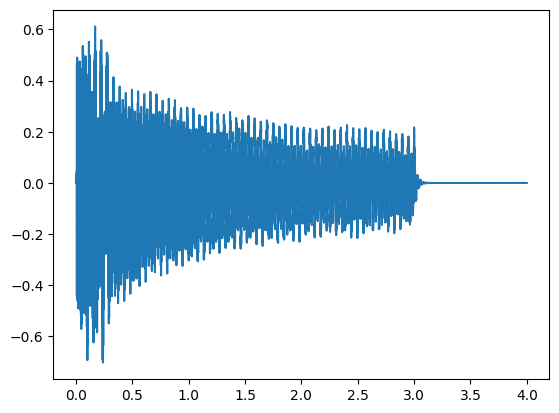

In [24]:
#Generate a random waveform
import matplotlib.pyplot as plt
import soundfile as sf
#Pick a random sample of each instrument
filepaths, labels = f.pick_samples_and_classify(instrument_list)

#Extract .wav data into to a list
waveforms = f.add_waveform_to_list(filepaths, path = inst_path)

#Combine the waveforms
combined_waveform = f.combine_waveforms(waveforms)

print(waveforms)
#Save the combined waveform to a wav file using librosa
sf.write('combined_waveform.wav', combined_waveform, 16000)

frame_rate = 16000
time = np.linspace(0, len(combined_waveform)/frame_rate, num=len(combined_waveform))

plt.figure()
plt.plot(time, combined_waveform)


In [25]:
filepaths

[array(['guitar_electronic_028-069-025.wav'], dtype='<U33'),
 array(['flute_synthetic_000-026-025.wav'], dtype='<U31')]

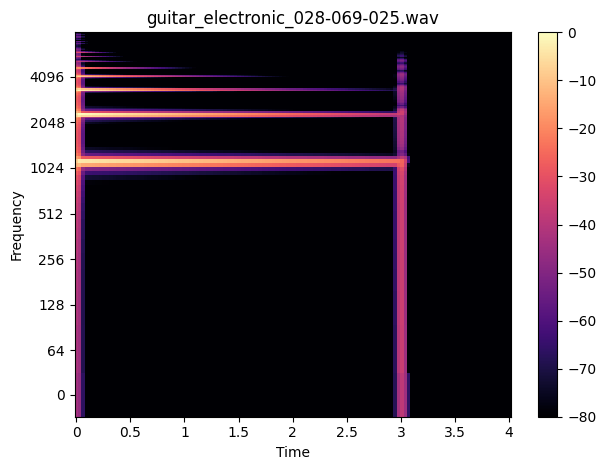

16000


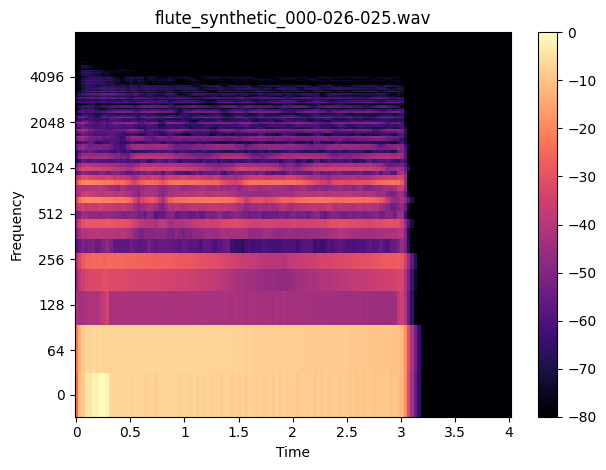

16000


In [26]:
import wave
import matplotlib.pyplot as plt

def to_mel_spectrogram(spectrogram, sr, n_mels = 128):
    return librosa.feature.melspectrogram(y = None, sr=sr, S = spectrogram, n_mels=128)


for file in filepaths:
    st_file = "C:/Users/ian03/Desktop/MLproject/AudioNNRepository/audio/" + file[0]
    
    waveform, input_sr = librosa.load(st_file, sr=None)
    spectro = f.waveform_to_spectrogram(waveform)
    mel_spectro = to_mel_spectrogram(spectro, input_sr)
    plt.figure()
    librosa.display.specshow(librosa.amplitude_to_db(mel_spectro, ref=np.max), sr=input_sr, x_axis='time', y_axis='log')
    plt.colorbar()
    plt.title(file[0])
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    print(input_sr)

    


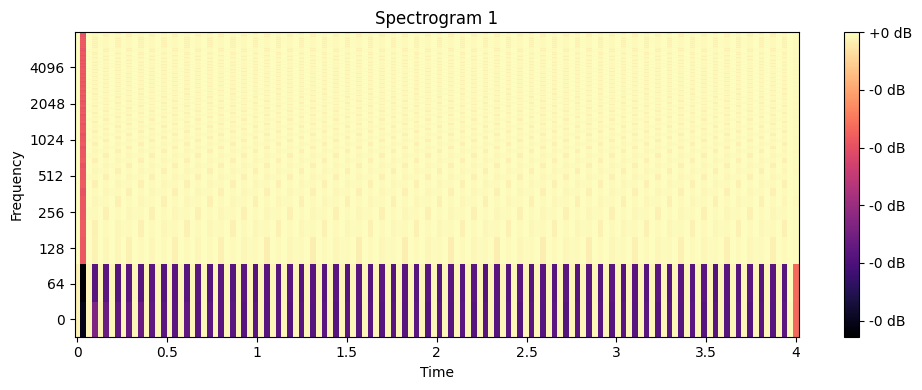

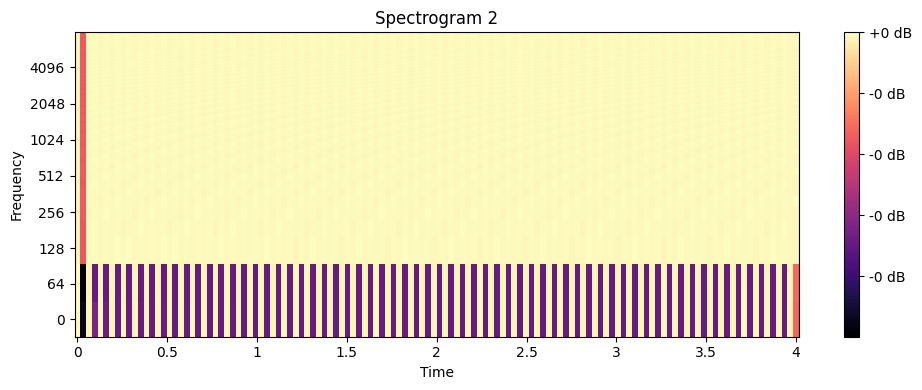

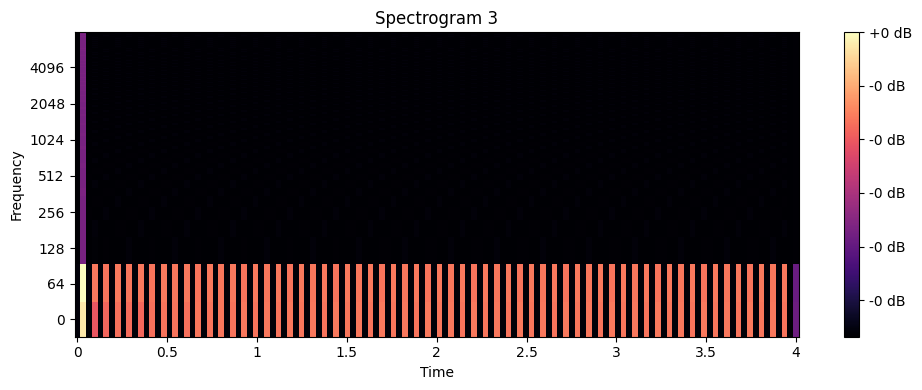

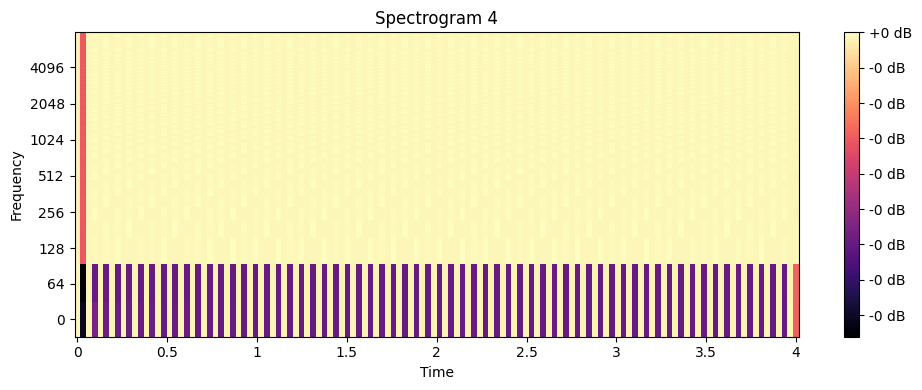

In [12]:

with wave.open("combined_waveform.wav", "rb") as wave_file:
    input_audio = wave_file.readframes(-1)
    input_sr = wave_file.getframerate()


model = UNetDConv(in_channels=1, out_channels=4, hidden_size=4, num_layers=2)  # Example with 2 output channels
model.load_state_dict(torch.load('your_model_weights.pth'))


combined_waveform, input_sr = librosa.load("combined_waveform.wav", sr = None)

spectrogam = f.waveform_to_spectrogram(combined_waveform)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetDConv(in_channels=1, out_channels=4, hidden_size=4, num_layers=2)
model.load_state_dict(torch.load('your_model_weights.pth'))
#model.eval()

input_tensor = torch.tensor(to_mel_spectrogram(spectrogam, 22050), dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float32)

with torch.no_grad():
    output_tensor = model(input_tensor)

def plot_seperated_spectrogram(output_tensor, sr):
    for i, spec in enumerate(output_tensor):
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Spectrogram {i + 1}')
        plt.xlabel('Time')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()


output_tensor = output_tensor.squeeze().cpu().numpy()
plot_seperated_spectrogram(output_tensor, input_sr)

In [11]:
import os
output_folder = "output_audio"
os.makedirs(output_folder, exist_ok=True)   
for i, source in enumerate(output_tensor):
    output_filepath = os.path.join(output_folder, f"output_{i}.wav")
    f.spectrogram_to_audio(source, input_sr, output_filepath)

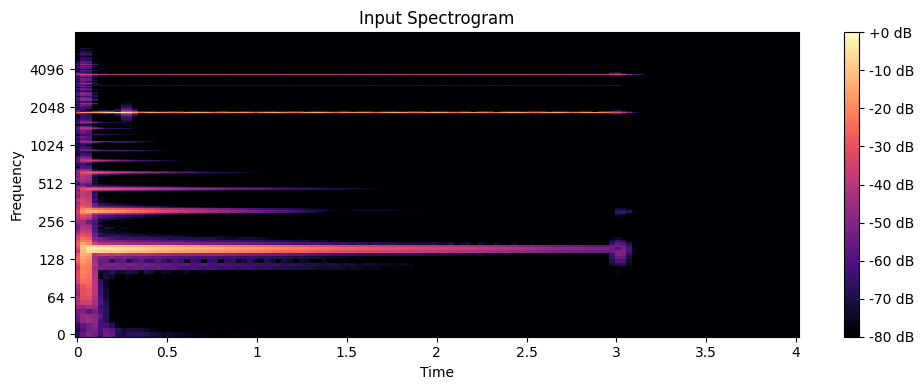

In [12]:
#Plot the input spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(spectrogam, ref=np.max), sr=input_sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Input Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
